This is a script designed to compute the parameters (i.e. size and ionisation) of a hot-spot on the accretion disc given its periodic effect on the light curve (T = 86 ks) and on the measured ionisation parameter (i.e. via relxill XSPEC model). 

The spot parameters can be computed using the simple relationship:
$ \left(A_{\mathrm{disc}} + A_{\mathrm{spot}}\right)\xi_{\mathrm{total}} = \left(A_{\mathrm{disc}}-A_{\mathrm{spot}}\right)\xi_{\mathrm{disc}} + A_{\mathrm{spot}}\xi_{\mathrm{spot}} $

We start by first computing the region of the accretion disc from which 99.9 per cent of X-rays are reflected off of the disc (i.e. inside some critical radius $r_{\mathrm{crit}}$). This determines the outer radius $r_{\mathrm{out}}$ of the disc, with the inner radius $r_{\mathrm{in}}$ being set by the black hole spin $a=0.998$ giving $r_{\mathrm{disc}} = 1.235r_g$. During the relxill modelling we assumed a constant emissivity profile over all radii of the disc with emissivity index $q=3$.

In [36]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Some standard things that I add to every script ###############
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['axes.linewidth'] = 1 #set the value globally
# plt.rc('font',family='serif')
# plt.rc('text',usetex=True)
###################################################################

### Function to compute the general relativistic correction to the disc area 
def gr_area(dr,r,a):
    rhosq = r*r + (a*a)*(np.cos(np.pi/2)*np.cos(np.pi/2))
    delta = r*r - 2*r + a*a
    sigmasq = (r*r + a*a)*(r*r + a*a) - (a*a)*delta*(np.sin(np.pi/2)*np.sin(np.pi/2))
    w = 2*a*r/sigmasq

    u = 1/r
    k = (1 - 2*u + a*u*np.sqrt(u)) / np.sqrt(1 - 3*u + 2*a*u*np.sqrt(u))
    h = (1 + (a*a)*(u*u) - 2*a*u*np.sqrt(u)) / (np.sqrt(u)*np.sqrt(1 - 3*u + 2*a*u*np.sqrt(u)))

    vdt = (((r*r)*(r*r + a*a) + 2*a*a*r)*k - 2*a*r*h) / (r*r*(1 - 2/r)*(r*r + a*a) + 2*a*a*r)
    vdr = 0.0
    vdtheta = 0.0
    vdphi = (2*a*r*k + (r*r -2*r)*h) / (r*r*(1 - 2/r)*(r*r + a*a) + 2*a*a*r)
    omega  = 1 / (a + r*np.sqrt(r))

    gr_corr = np.sqrt(r*r + a*a + 2.0*a*a*r / rhosq)*np.sqrt(rhosq / delta)*dr

    e2nu = rhosq*delta/sigmasq
    e2psi  = sigmasq*(np.sin(np.pi/2.0)*np.sin(np.pi/2.0))/rhosq

    gtt = e2nu - e2psi*w*w
    gtphi = e2psi*w
    gphit = e2psi*w
    grr = -rhosq/delta
    gthetatheta = -rhosq
    gphiphi= -e2psi

    ### time
    e0t = (1 / np.sqrt(e2nu)) / np.sqrt(1 - (omega - w)*(omega - w)*e2psi/e2nu)
    e0r = 0.0
    e0theta = 0.0
    e0phi = (omega / np.sqrt(e2nu)) / np.sqrt(1 - (omega - w)*(omega - w)*e2psi/e2nu)

    ### radius
    e1t = 0.0
    e1r = np.sqrt(delta)/np.sqrt(rhosq)
    e1theta = 0.0
    e1phi = 0.0

    ### theta
    e2t = 0.0
    e2r = 0.0
    e2theta = 1/np.sqrt(rhosq)
    e2phi = 0.0

    ### phi
    e3t = ((omega - w)*(np.sqrt(e2psi/e2nu))) / np.sqrt(e2nu - (omega - w)*(omega - w)*e2psi)
    e3r = 0.0
    e3theta = 0.0
    e3phi = ((e2nu + omega*w*e2psi - w*w*e2psi) / (np.sqrt(e2psi/e2nu))) / np.sqrt(e2nu - (omega - w)*(omega - w)*e2psi)

    vt = gtt*vdt*e0t + gtphi*vdt*e0phi + gphit*vdphi*e0t + gphiphi*vdphi*e0phi
    vr = grr*vdr*e1r
    vtheta = gthetatheta*vdtheta*e2theta
    vphi = gtt*vdt*e3t + gtphi*vdt*e3phi + gphit*vdphi*e3t + gphiphi*vdphi*e3phi

    gamma  = vt
    func_area = gr_corr / gamma

    return func_area


### Compute the emissivity of the accretion disc assuming q=3
radius = np.logspace(np.log10(1.235),np.log10(1000),1001)
emiss = radius**(-3.0)	# the emissivity profile used in the modelling with relxill (qin,qout=3.0)
total = np.sum(emiss)
s = 0

### Determine where 99.9% of the reflected X-rays originate
emiss_amount = 0.999
for i in range (0,len(emiss)):
    s += emiss[i]
    if ((s/total) >= emiss_amount):
        emiss_rad = radius[i]
        break
print("Critical radius r_crit ~= {0:.2f}".format(emiss_rad), "r_g")


Critical radius r_crit ~= 12.28 r_g


The above value corresponds to the critical radius $r_{\mathrm{crit}}$ within which 99.9 per cent of the reflected X-rays originate.

We now determine the general relativistically corrected accretion disc area.

Normal disc area       = 469.01 r_g^2
GR corrected disc area = 582.38 r_g^2
Normal / GR = 0.81


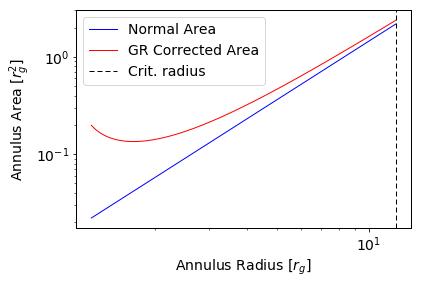

In [42]:
### Disc parameters (inner, outer radius and ionisatio w/o the spot)
disc_r_in  = 1.235
disc_r_out = emiss_rad
disc_xi    = 2.8
total_xi   = 2.99

### Calculate both the normal & general relativistically corrected areas of the disc
disc_r = np.logspace(np.log10(disc_r_in), np.log10(disc_r_out), 1001)
disc_eu_area = np.zeros(len(disc_r))
disc_gr_area = np.zeros(len(disc_r))
total_disc_eu_area = 0.0
total_disc_gr_area = 0.0

for i in range (0, len(disc_r)-1):
    dr = disc_r[i+1]-disc_r[i]
    disc_eu_area[i] = np.pi*(disc_r[i+1]**2.0-disc_r[i]**2.0)
    disc_gr_area[i] = gr_area(dr, disc_r[i], 0.998)*2*np.pi

total_disc_eu_area = np.sum(disc_eu_area)
print("Normal disc area       = {0:.2f}".format(total_disc_eu_area),"r_g^2")
total_disc_gr_area = np.sum(disc_gr_area)
print("GR corrected disc area = {0:.2f}".format(total_disc_gr_area),"r_g^2")

print("Normal / GR = {0:.2f}".format(total_disc_eu_area/total_disc_gr_area))

plt.figure()
plt.loglog(disc_r[:-1], disc_eu_area[:-1], '-b', linewidth=1.0, label='Normal Area')
plt.loglog(disc_r[:-1], disc_gr_area[:-1], '-r', linewidth=1.0, label='GR Corrected Area')
plt.axvline(x=emiss_rad, color='k', dashes=[5,3], linewidth=1.0, label='Crit. radius')
plt.xlabel(r"Annulus Radius $[r_g]$")
plt.ylabel(r"Annulus Area $[r_g^2]$")
plt.legend(loc='best')
plt.show()

From the above result we see the significance of including the general relativistic correction to the disc area (given as annulus radius as the plotted area corresponds to the area of an annulus of the given radius).

We now compute the spot parameters using the aforementioned relationship between the spot and disc areas and ionisation parameters.

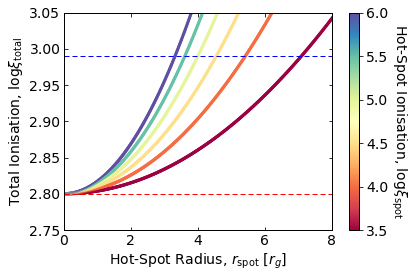

In [43]:
### Set up the spot and calculate its effect on the disc ionisation
max_spot_r  = 10.0-1.235
spot_radius = np.linspace(0.0, max_spot_r, 501)
# spot_xi     = np.linspace(disc_xi,4.7,101)
spot_xi     = np.array([3.5,4.0,4.5,5.0,5.5,6.0])

c = 0
spot_params = np.zeros([1,3])
disc_area_CONST = total_disc_gr_area

for i in range (0,len(spot_radius)):
    spot_area = np.pi*spot_radius[i]**2.0
    disc_area = disc_area_CONST-spot_area

    for j in range (0,len(spot_xi)):
        xi_calc = (spot_area*spot_xi[j]+disc_area*disc_xi)/(spot_area+disc_area)

        ### Use this to find ALL spot paramters
        c += 1
        spot_params = np.append(spot_params, [[spot_radius[i],spot_xi[j],xi_calc]], axis=0)
        # spot_params = np.append(spot_params, [[spot_area,spot_xi[j],xi_calc]], axis=0)

        ### Or use this to find only the spot parameters that give total_xi within some tolerance
        # if (abs(xi_calc-total_xi)<=1e-2):
        # 	c += 1
        # 	spot_params = np.append(spot_params, [[spot_radius[i],spot_xi[j],xi_calc]], axis=0)

spot_params = spot_params[1:]

### Plot everything up
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.scatter(spot_params[:,0], spot_params[:,2], s=5, c=spot_params[:,1], cmap='Spectral')
# cax = ax.scatter(spot_params[:,0], spot_params[:,1], s=5, c='k')
ax.axhline(y=disc_xi, color='r', dashes=[5,3], linewidth=1)
ax.axhline(y=total_xi, color='b', dashes=[5,3], linewidth=1)
# ax.fill_between(x=spot_params[:,0], y1=disc_xi-0.4, y2=disc_xi+0.3, facecolor='k', alpha=0.15)
# ax.fill_between(x=spot_params[:,0], y1=total_xi-0.22, y2=total_xi+0.08, facecolor='k', alpha=0.15)
ax.set_xlabel(r"Hot-Spot Radius, $r_{\mathrm{spot}}$ $[r_g]$")
ax.set_ylabel(r"Total Ionisation, $\log\xi_{\mathrm{total}}$")
ax.set_xlim(left=0.0,right=8.0)
ax.set_ylim(bottom=2.75,top=3.05)
ax.tick_params(axis='both', which='both', direction='in', top='on', right='on')
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel(r"Hot-Spot Ionisation, $\log\xi_{\mathrm{spot}}$", rotation=270, labelpad=20.0)
plt.show()

From the above plot we see that by allowing for a highly ionised hot-spot on the accretion disc (i.e. $\log\xi = 6$) we can effectively raise the observed total ionisation parameter as $\log\xi = 3$ for a hot-spot with radius $r_{\mathrm{spot}} ~= 3 r_g$.